# Predicting Habitat condition from NDVI/NDWI

Exploratory data analysis and model fitting



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [256]:
ndvi = pd.read_csv('./Desktop/S2_NDVI_MEDIAN_TABLE.csv',
                   usecols=np.arange(1, 12),
                   index_col='ID')
ndvi.columns = pd.to_datetime(
    [x.split('_')[0] for x in ndvi.columns])
habitats = pd.read_csv(
    './Desktop/SSSI_SW_Grasslands/SSSI_Site_'
    'Condition_Units_SW_Dissolved_Grasslands.csv',
    index_col='ID',
    usecols=['ID', 'HABITAT', 'CONDITION', 'COND_DATE'],
    parse_dates=['COND_DATE'])
habitats = habitats[~habitats.HABITAT.isnull()]
habitats.head()

,CONDITION,COND_DATE,HABITAT
ID,,,
1006005.0,UNFAVOURABLE RECOVERING,2012-10-30,Lowland Dry Acid Grassland
1006006.0,UNFAVOURABLE RECOVERING,2012-10-30,Lowland Dry Acid Grassland
1001484.0,FAVOURABLE,2012-10-09,Lowland Calcareous Grassland
1001486.0,FAVOURABLE,2012-08-30,Lowland Calcareous Grassland
1001487.0,UNFAVOURABLE NO CHANGE,2012-10-09,Lowland Calcareous Grassland


## Habitat data:

Habitat data has three columns of interest:
* the type of habitat
* the condition of the habitat
* the date the condition assessment was made

### condition

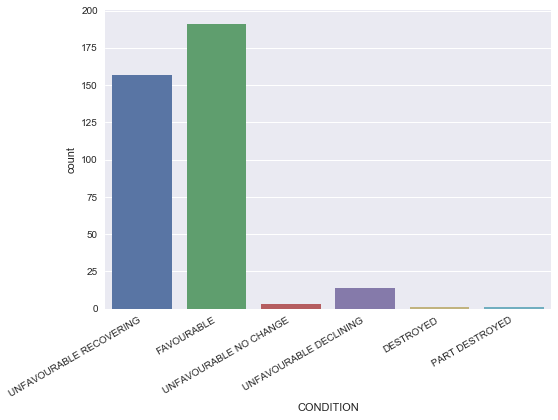

In [257]:
ax = sns.countplot(x='CONDITION', data=habitats)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()

As there are so few examples of the more complex classes of habitat condition, lets simplify the data by reducing the number of labels to just two classes: favourable and unfavourable

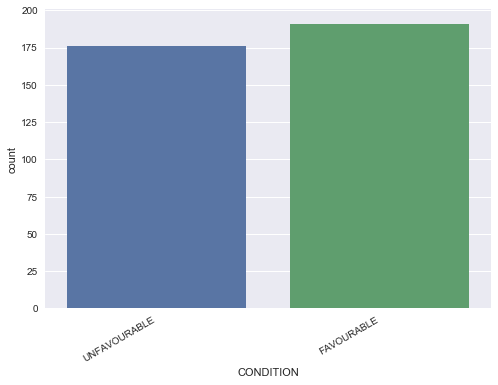

In [258]:
habitats['CONDITION'] = habitats.CONDITION.str.replace('^(?!FAV).*',
                                                       'UNFAVOURABLE')
ax = sns.countplot(x='CONDITION', data=habitats)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()

### date

Most of the condition assessments appear to have been made in 2009-2012.

This may cause issues as the NDVI data is all from S2 images from 2015 onwards (the satellite was only launched in 2015)

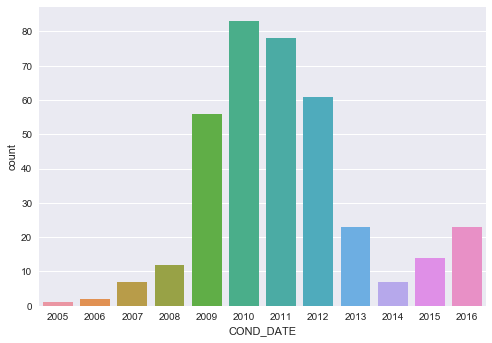

In [259]:
sns.countplot(habitats.COND_DATE.dt.year)
plt.show()

Condition assessments are relatively evenly distributed through the year, presumably this should not have any impact on the assessment outcome

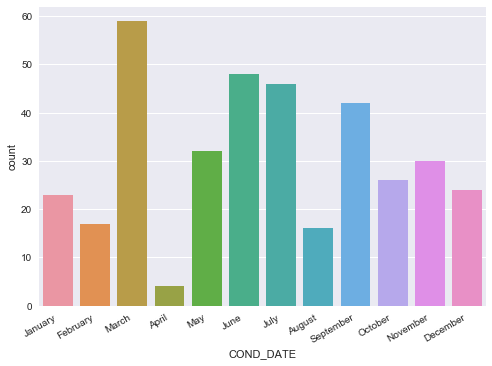

In [260]:
dates = habitats.COND_DATE.dt.strftime('%m %B')
_, m = zip(*sorted([x.split() for x in set(dates)], key=lambda x: x[0]))
ax = sns.countplot(habitats.COND_DATE.dt.strftime('%B'), order=m)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()

### habitat type

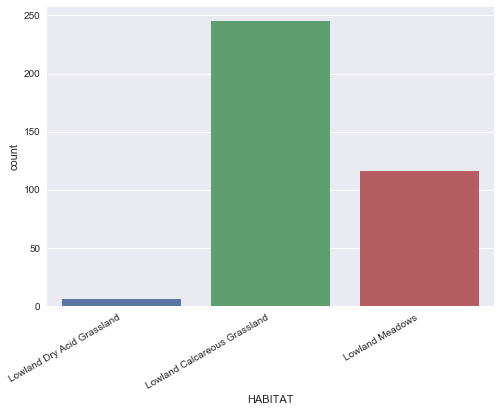

In [261]:
ax = sns.countplot(x='HABITAT', data=habitats)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()

### Correlation between habitat type and condition:

There does not appear to be any strong correlation between the type of habitat and the condition, at least in this area of the country

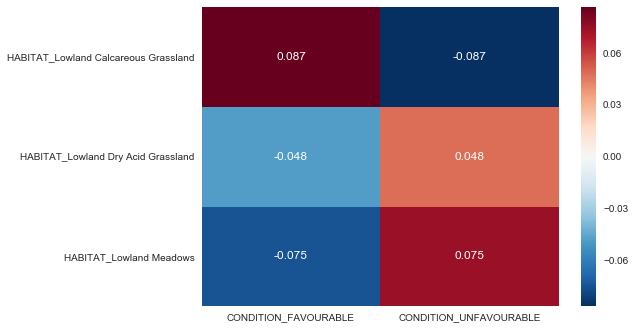

In [262]:
corrs = pd.get_dummies(habitats[['HABITAT', 'CONDITION']]).corr()
corrs = corrs.loc[corrs.columns.str.startswith('HABITAT'),
                  corrs.columns.str.startswith('CONDITION')]
sns.heatmap(corrs, annot=True)
plt.show()

## NDVI timeseries data

In [263]:
ndvi_data = habitats.merge(ndvi, left_index=True, right_index=True)
ndvi_data.head()

,CONDITION,COND_DATE,HABITAT,2015-12-09 00:00:00,2015-12-29 00:00:00,2016-04-20 00:00:00,2016-05-30 00:00:00,2016-06-06 00:00:00,2016-07-19 00:00:00,2016-08-15 00:00:00,2016-09-14 00:00:00,2016-10-04 00:00:00,2016-11-06 00:00:00
ID,,,,,,,,,,,,,
1000011.0,UNFAVOURABLE,2011-06-23,Lowland Meadows,0.628786,0.618991,0.757110,0.593632,NaN,0.827620,0.641485,0.811732,NaN,0.840761
1000021.0,FAVOURABLE,2010-05-24,Lowland Meadows,0.616304,0.815800,0.811207,NaN,0.708916,0.562345,0.830140,NaN,NaN,NaN
1000022.0,FAVOURABLE,2010-05-24,Lowland Meadows,0.688519,0.841515,0.871419,NaN,NaN,0.894549,0.860996,0.504215,NaN,NaN
1001229.0,UNFAVOURABLE,2013-09-08,Lowland Calcareous Grassland,0.626889,0.735740,0.785975,NaN,0.938073,0.915554,0.903531,NaN,NaN,NaN
1001230.0,UNFAVOURABLE,2010-12-02,Lowland Calcareous Grassland,0.704703,0.755337,0.732695,NaN,0.910990,0.908090,0.893780,NaN,NaN,NaN


### Timeseries dates:

The S2 images were all taken in December 2015 or in 2016, so it is possible that some of the condition assessments, which were mostly made in the period 2009-2012, are a bit out of date

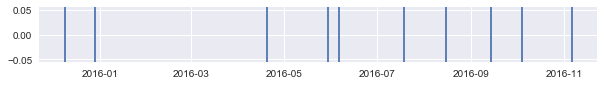

In [266]:
fig, ax = plt.subplots(figsize=(10, 1))
for date in ndvi.columns.values:
    plt.axvline(date)
ax.autoscale()
plt.show()

### Missing data

Some of the scenes appear to have a lot of missing data, this has affected the distribution of these variables as can be seen in the violin plots below.

It is probably best to discard these variables when modelling

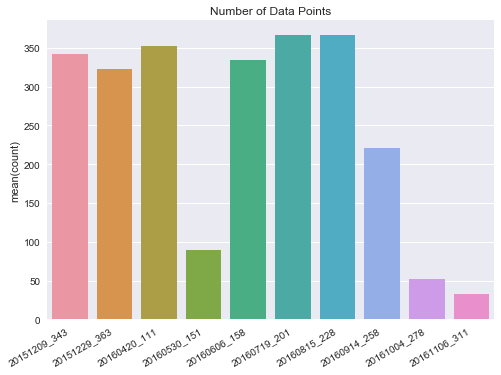

In [118]:
desc = ndvi_data.describe()
ax = sns.barplot(x=desc.columns, y=desc.loc['count'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_title('Number of Data Points')
plt.show()

C:\Users\Matthew\Miniconda3\envs\lm2_test\lib\site-packages\seaborn\categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


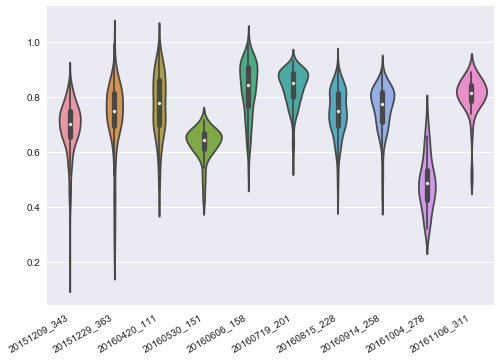

,20151209_343,20151229_363,20160420_111,20160530_151,20160606_158,20160719_201,20160815_228,20160914_258,20161004_278,20161106_311
count,342.000000,323.000000,353.000000,90.000000,334.000000,367.000000,366.000000,221.000000,52.000000,33.000000
mean,0.688132,0.727252,0.769826,0.629420,0.826309,0.832452,0.743012,0.757341,0.486199,0.804507
std,0.093015,0.132247,0.113704,0.058169,0.099942,0.067544,0.086725,0.082910,0.097034,0.068328
min,0.148523,0.219532,0.435479,0.419408,0.519944,0.557857,0.428057,0.428763,0.317477,0.514198
25%,0.651592,0.691580,0.695763,0.608698,0.766171,0.797983,0.692517,0.708194,0.425122,0.784564
50%,0.701475,0.746345,0.777068,0.641741,0.842908,0.848894,0.748295,0.774376,0.486331,0.813993
75%,0.746785,0.812580,0.859472,0.666697,0.907225,0.884487,0.813565,0.817324,0.534226,0.840761
max,0.867535,0.995104,0.998810,0.714286,0.996001,0.931182,0.922725,0.895036,0.717920,0.888635


In [119]:
ax = sns.violinplot(ndvi_data._get_numeric_data())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()
desc

In [120]:
ndvi_data.drop(['20161106_311', '20161004_278', '20160530_151'],
               axis=1, 
               inplace=True)
ndvi_data.head()

,CONDITION,COND_DATE,HABITAT,20151209_343,20151229_363,20160420_111,20160606_158,20160719_201,20160815_228,20160914_258
ID,,,,,,,,,,
1000011.0,UNFAVOURABLE,2011-06-23,Lowland Meadows,0.628786,0.618991,0.757110,NaN,0.827620,0.641485,0.811732
1000021.0,FAVOURABLE,2010-05-24,Lowland Meadows,0.616304,0.815800,0.811207,0.708916,0.562345,0.830140,NaN
1000022.0,FAVOURABLE,2010-05-24,Lowland Meadows,0.688519,0.841515,0.871419,NaN,0.894549,0.860996,0.504215
1001229.0,UNFAVOURABLE,2013-09-08,Lowland Calcareous Grassland,0.626889,0.735740,0.785975,0.938073,0.915554,0.903531,NaN
1001230.0,UNFAVOURABLE,2010-12-02,Lowland Calcareous Grassland,0.704703,0.755337,0.732695,0.910990,0.908090,0.893780,NaN


### Multicolinearity:

Because this is time series data, the independent variables are likely to be fairly strongly correlated:

C:\Users\Matthew\Miniconda3\envs\lm2_test\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\Matthew\Miniconda3\envs\lm2_test\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


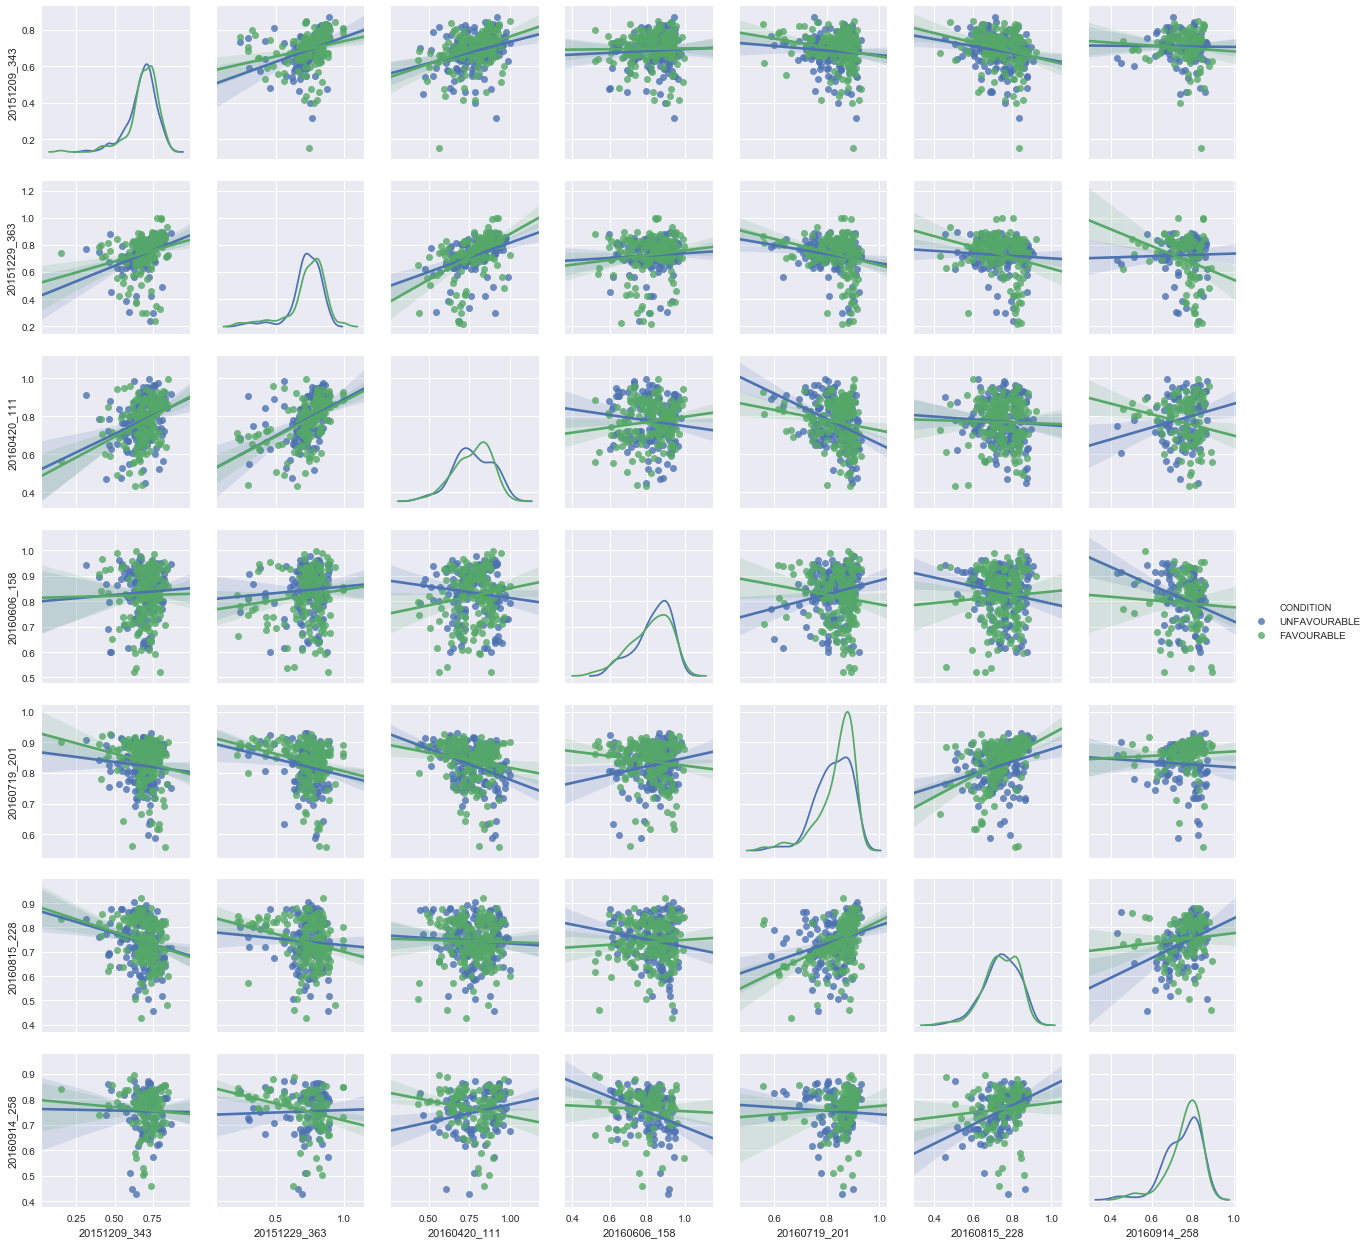

In [121]:
grid = sns.PairGrid(ndvi_data[cols], hue='CONDITION')
grid.map_diag(sns.kdeplot)
grid.map_offdiag(sns.regplot)
grid.add_legend()
plt.show()

In fact the correlations between the time series data is fairly low (high variability?) however multicolinearity only needs to be weak to have a strong effect on linear models. We could use a feature reduction method to get around this, or use random forests, which are fairly robust to correlation between predictors

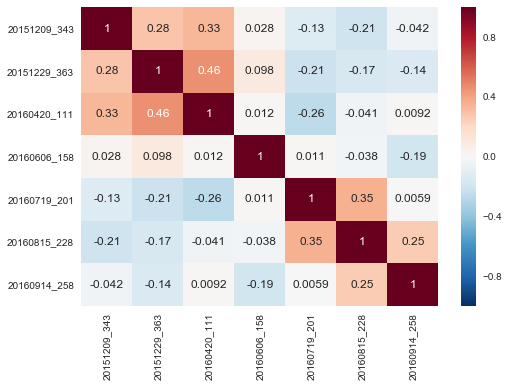

In [122]:
sns.heatmap(ndvi_data._get_numeric_data().corr(), annot=True)
plt.show()

### Correlation of NDVI with condition:

Differences in the distributions of NDVIs of favourable and unfavourable habitats seem to be very subtle.

C:\Users\Matthew\Miniconda3\envs\lm2_test\lib\site-packages\seaborn\categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


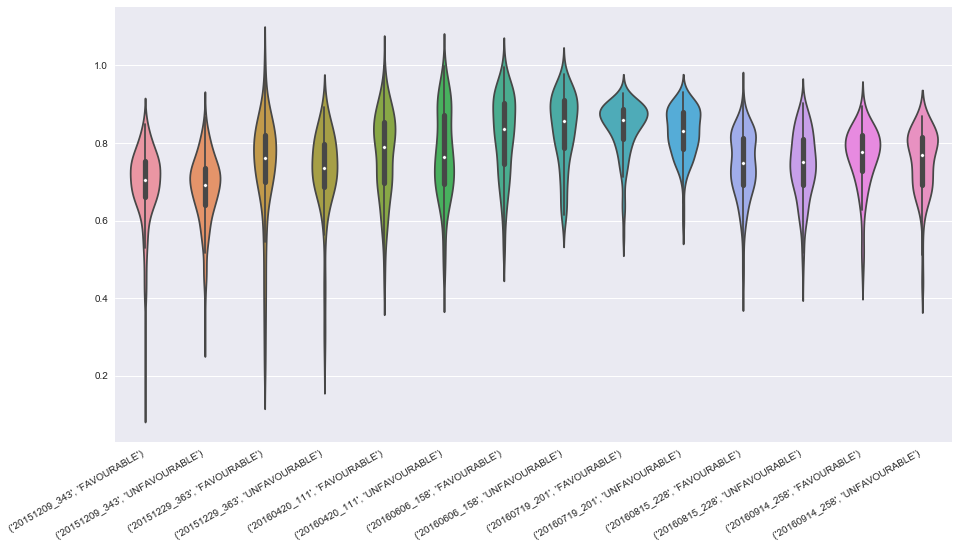

In [123]:
cols = ['CONDITION', *ndvi_data._get_numeric_data().columns.values]
fig = plt.figure(figsize=(15, 8))
ax = sns.violinplot(ndvi_data[cols].pivot(columns='CONDITION'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()

## Modelling condition from NDVI

In [228]:
from knnimpute import knn_impute_reference as knn_impute
from sklearn.model_selection import train_test_split

X = ndvi_data._get_numeric_data().values
y = pd.get_dummies(ndvi_data.CONDITION.values)['FAVOURABLE'].values
X = knn_impute(X, np.isnan(X), k=10)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1011)

In [229]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50,
                            random_state=1000,
                            max_depth=4).fit(X_train, y_train)
rf.score(X_test, y_test)

0.6216216216216216

[[23 14]
 [14 23]]


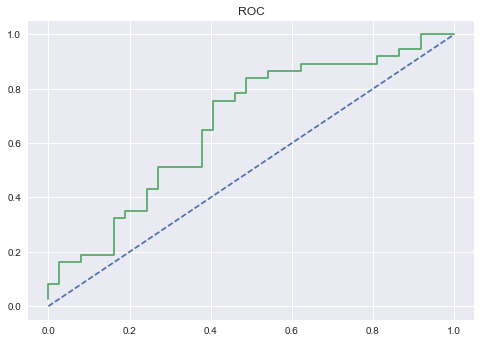

In [230]:
from sklearn.metrics import confusion_matrix, roc_curve

pred = rf.predict(X_test)
print(confusion_matrix(pred, y_test))
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], ls='--')
plt.plot(fpr, tpr)
ax.set_title('ROC')
plt.show()

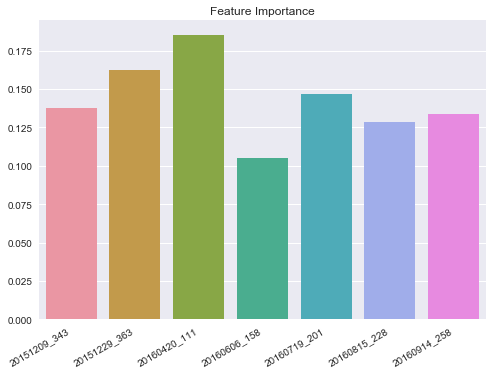

In [231]:
ax = sns.barplot(x=ndvi_data._get_numeric_data().columns,
                 y=rf.feature_importances_)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_title('Feature Importance')
plt.show()

## NDWI

The NDWI is calculated by the the equation:

![eq](http://spaceanalyzer.com/images/sa_spaceye/documentation/NDWI.JPG)

and is highly associated with changes in vegetation water content and spongy mesophyll structure, therefore may be a good proxy for grassland condition

In [232]:
ndwi = pd.read_csv('./Desktop/S2_NDWI_TABLE.csv',
                   usecols=np.arange(1, 12),
                   index_col='ID')
ndwi_data = habitats.merge(ndwi, left_index=True, right_index=True)
ndwi_data.head()

,CONDITION,COND_DATE,HABITAT,20151209_343,20151229_363,20160420_111,20160530_151,20160606_158,20160719_201,20160815_228,20160914_258,20161004_278,20161106_311
ID,,,,,,,,,,,,,
1000011.0,UNFAVOURABLE,2011-06-23,Lowland Meadows,0.165336,0.133519,0.140783,0.315326,NaN,0.298319,0.102571,0.276188,NaN,0.219596
1000021.0,FAVOURABLE,2010-05-24,Lowland Meadows,0.191584,0.175755,0.175012,NaN,0.325543,0.012118,0.199021,NaN,NaN,NaN
1000022.0,FAVOURABLE,2010-05-24,Lowland Meadows,0.236950,0.212695,0.244909,NaN,NaN,0.369953,0.281859,0.059447,NaN,NaN
1001229.0,UNFAVOURABLE,2013-09-08,Lowland Calcareous Grassland,0.112533,0.087557,0.111777,NaN,0.368501,0.355015,0.343485,NaN,NaN,NaN
1001230.0,UNFAVOURABLE,2010-12-02,Lowland Calcareous Grassland,0.166698,0.147675,0.092943,NaN,0.296681,0.374064,0.372327,NaN,NaN,NaN


### Missing data

The same scenes are used to produce the NDWI and so it has the same missing data. We will again remove these columns

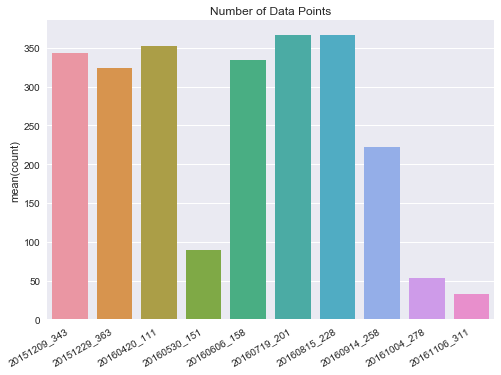

In [233]:
desc2 = ndwi_data.describe()
ax = sns.barplot(x=desc2.columns, y=desc2.loc['count'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_title('Number of Data Points')
plt.show()

In [234]:
ndwi_data.drop(['20161106_311', '20161004_278', '20160530_151'],
               axis=1, 
               inplace=True)
ndwi_data.head()

,CONDITION,COND_DATE,HABITAT,20151209_343,20151229_363,20160420_111,20160606_158,20160719_201,20160815_228,20160914_258
ID,,,,,,,,,,
1000011.0,UNFAVOURABLE,2011-06-23,Lowland Meadows,0.165336,0.133519,0.140783,NaN,0.298319,0.102571,0.276188
1000021.0,FAVOURABLE,2010-05-24,Lowland Meadows,0.191584,0.175755,0.175012,0.325543,0.012118,0.199021,NaN
1000022.0,FAVOURABLE,2010-05-24,Lowland Meadows,0.236950,0.212695,0.244909,NaN,0.369953,0.281859,0.059447
1001229.0,UNFAVOURABLE,2013-09-08,Lowland Calcareous Grassland,0.112533,0.087557,0.111777,0.368501,0.355015,0.343485,NaN
1001230.0,UNFAVOURABLE,2010-12-02,Lowland Calcareous Grassland,0.166698,0.147675,0.092943,0.296681,0.374064,0.372327,NaN


### Multicolinearity of NDWI

NDWI appears to vary less than NDVI over time and temporally close scenes are strongly correlated.

C:\Users\Matthew\Miniconda3\envs\lm2_test\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\Matthew\Miniconda3\envs\lm2_test\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


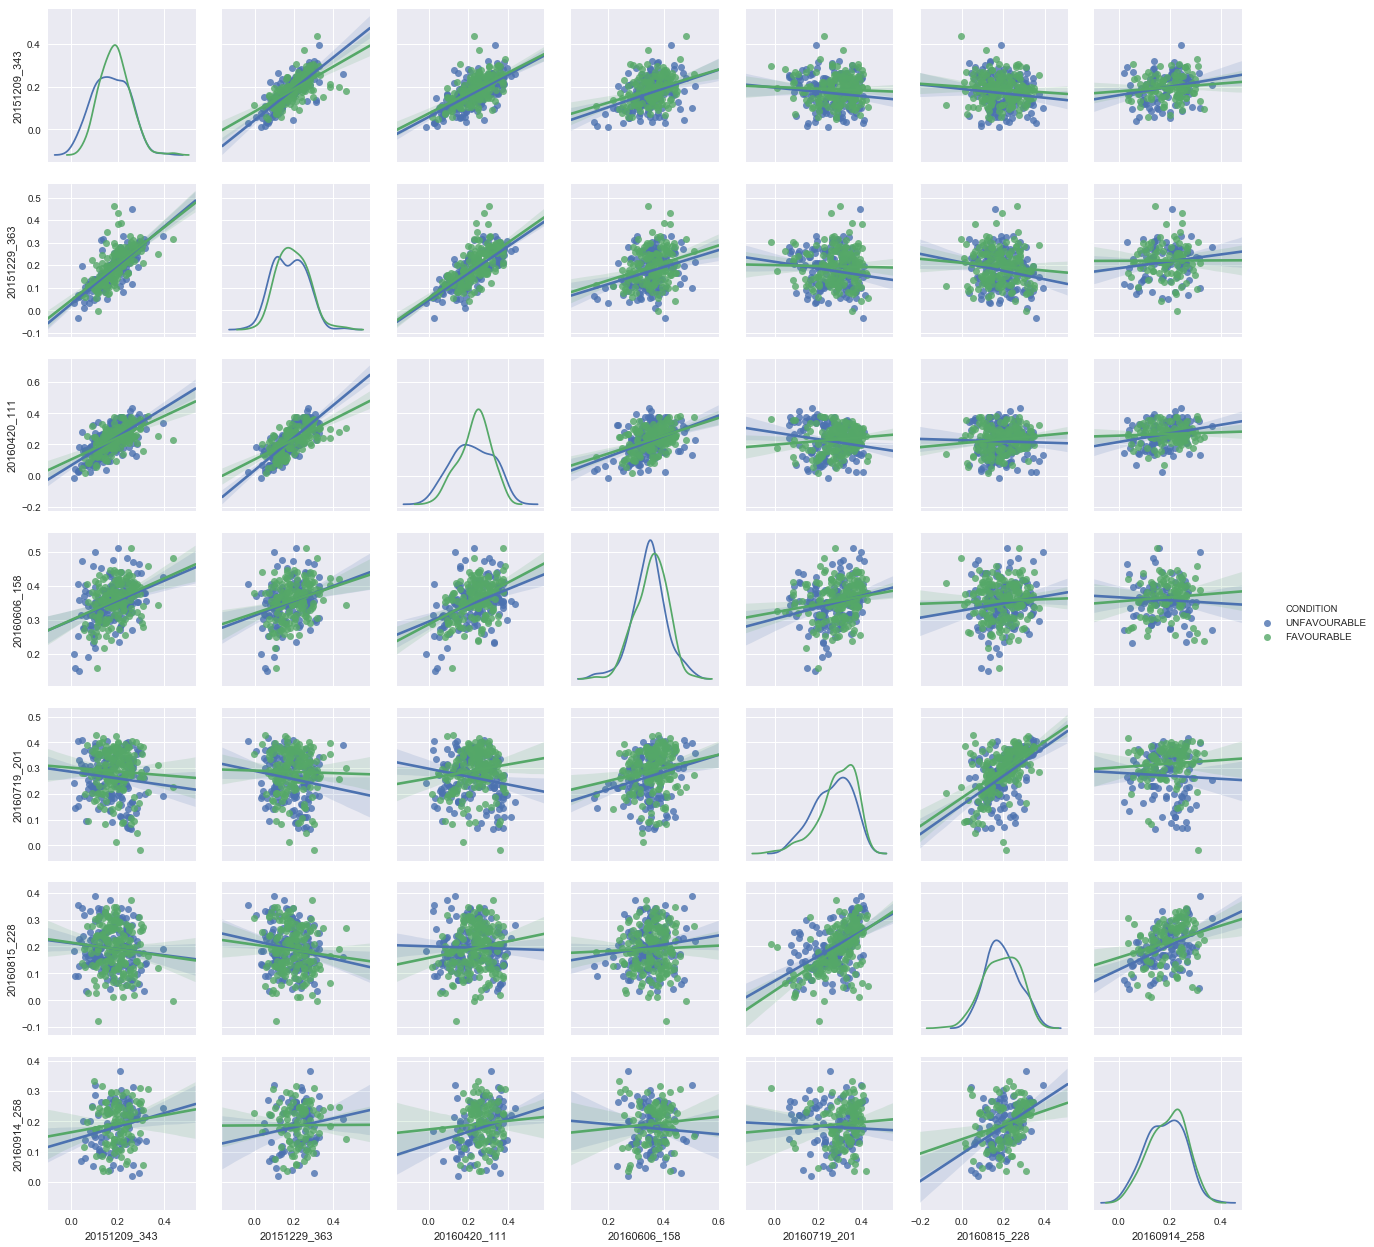

In [235]:
grid = sns.PairGrid(ndwi_data[cols], hue='CONDITION')
grid.map_diag(sns.kdeplot)
grid.map_offdiag(sns.regplot)
grid.add_legend()
plt.show()

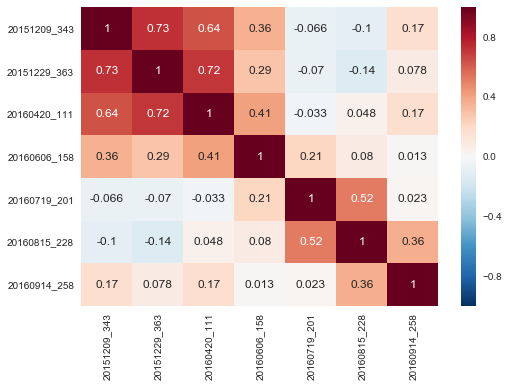

In [236]:
sns.heatmap(ndwi_data._get_numeric_data().corr(), annot=True)
plt.show()

### Correlation of NDWI with condition

The distributions of Favourable and unfavourable habitats again appear to be relatively similar, favourable conditions may have marginally higher median NDWI generally...

C:\Users\Matthew\Miniconda3\envs\lm2_test\lib\site-packages\seaborn\categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


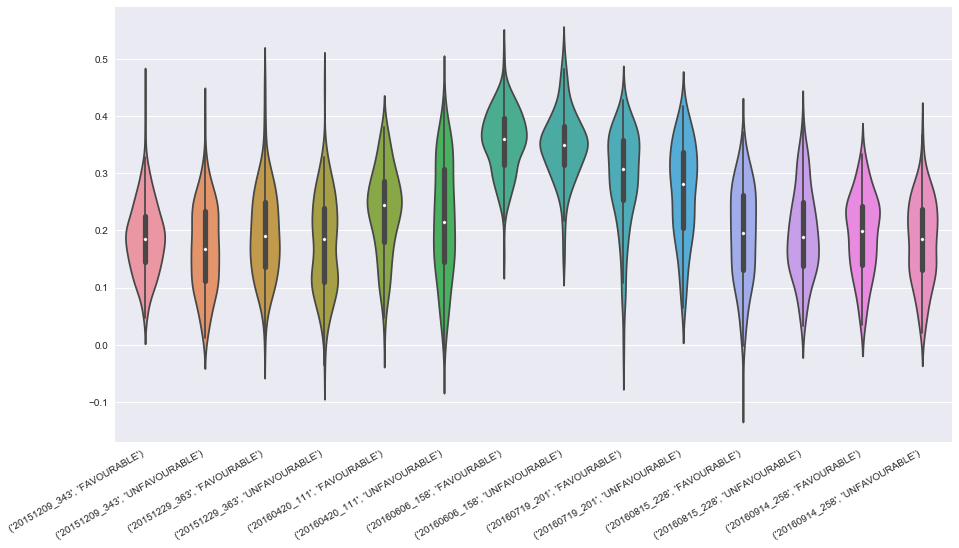

In [237]:
cols = ['CONDITION', *ndwi_data._get_numeric_data().columns.values]
fig = plt.figure(figsize=(15, 8))
ax = sns.violinplot(ndwi_data[cols].pivot(columns='CONDITION'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()

## Modelling condition from NDWI

Score: 0.662162162162
[[23 11]
 [14 26]]


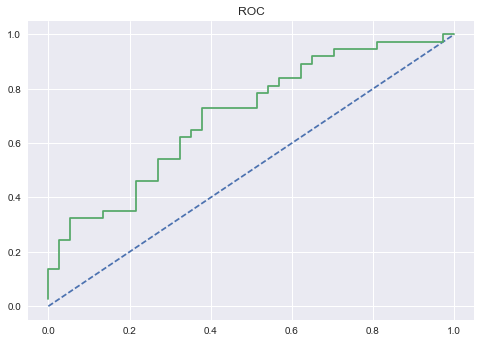

In [238]:
X = ndwi_data._get_numeric_data().values
y = pd.get_dummies(ndwi_data.CONDITION.values)['FAVOURABLE'].values
X = knn_impute(X, np.isnan(X), k=10)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1011)

rf = RandomForestClassifier(n_estimators=50,
                            random_state=1000,
                            max_depth=4).fit(X_train, y_train)
print('Score:', rf.score(X_test, y_test))
pred = rf.predict(X_test)
print(confusion_matrix(pred, y_test))
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], ls='--')
plt.plot(fpr, tpr)
ax.set_title('ROC')
plt.show()

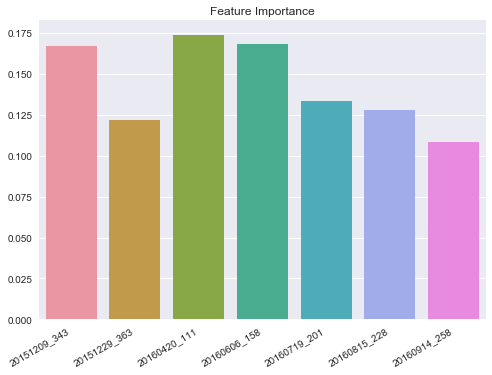

In [239]:
ax = sns.barplot(x=ndwi_data._get_numeric_data().columns,
                 y=rf.feature_importances_)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_title('Feature Importance')
plt.show()

## Modelling condition from NDVI and NDWI:

In [240]:
drops = ['HABITAT', 'CONDITION', 'COND_DATE']
ndvi_ndwi_data = ndvi_data.merge(ndwi_data.drop(drops, axis=1),
                                 left_index=True,
                                 right_index=True,
                                 suffixes=('_ndvi', '_ndwi'))
ndvi_ndwi_data.head()

,CONDITION,COND_DATE,HABITAT,20151209_343_ndvi,20151229_363_ndvi,20160420_111_ndvi,20160606_158_ndvi,20160719_201_ndvi,20160815_228_ndvi,20160914_258_ndvi,20151209_343_ndwi,20151229_363_ndwi,20160420_111_ndwi,20160606_158_ndwi,20160719_201_ndwi,20160815_228_ndwi,20160914_258_ndwi
ID,,,,,,,,,,,,,,,,,
1000011.0,UNFAVOURABLE,2011-06-23,Lowland Meadows,0.628786,0.618991,0.757110,NaN,0.827620,0.641485,0.811732,0.165336,0.133519,0.140783,NaN,0.298319,0.102571,0.276188
1000021.0,FAVOURABLE,2010-05-24,Lowland Meadows,0.616304,0.815800,0.811207,0.708916,0.562345,0.830140,NaN,0.191584,0.175755,0.175012,0.325543,0.012118,0.199021,NaN
1000022.0,FAVOURABLE,2010-05-24,Lowland Meadows,0.688519,0.841515,0.871419,NaN,0.894549,0.860996,0.504215,0.236950,0.212695,0.244909,NaN,0.369953,0.281859,0.059447
1001229.0,UNFAVOURABLE,2013-09-08,Lowland Calcareous Grassland,0.626889,0.735740,0.785975,0.938073,0.915554,0.903531,NaN,0.112533,0.087557,0.111777,0.368501,0.355015,0.343485,NaN
1001230.0,UNFAVOURABLE,2010-12-02,Lowland Calcareous Grassland,0.704703,0.755337,0.732695,0.910990,0.908090,0.893780,NaN,0.166698,0.147675,0.092943,0.296681,0.374064,0.372327,NaN


Score: 0.689189189189
[[25 11]
 [12 26]]


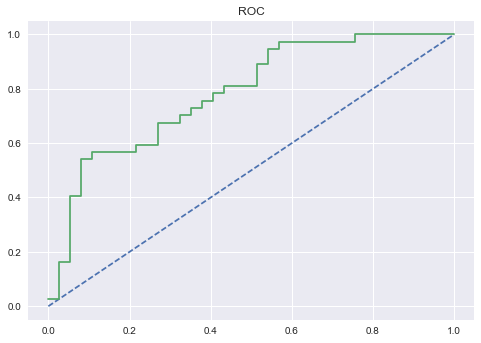

In [241]:
X = ndvi_ndwi_data._get_numeric_data().values
y = pd.get_dummies(ndvi_ndwi_data.CONDITION.values)['FAVOURABLE'].values
X = knn_impute(X, np.isnan(X), k=10)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1011)

rf = RandomForestClassifier(n_estimators=50,
                            random_state=1000,
                            max_depth=4).fit(X_train, y_train)
print('Score:', rf.score(X_test, y_test))
pred = rf.predict(X_test)
print(confusion_matrix(pred, y_test))
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], ls='--')
plt.plot(fpr, tpr)
ax.set_title('ROC')
plt.show()

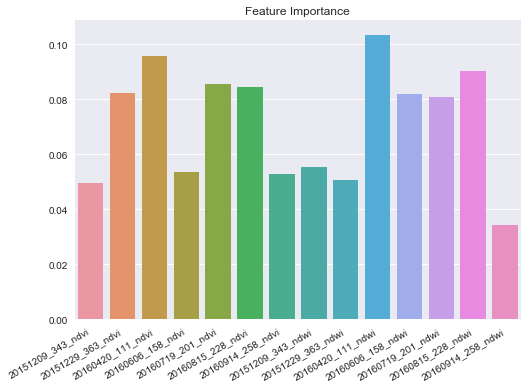

In [242]:
ax = sns.barplot(x=ndvi_ndwi_data._get_numeric_data().columns,
                 y=rf.feature_importances_)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_title('Feature Importance')
plt.show()

## How does the date of assessment affect the reliability of the model?

To assess this, we could:

* Stratify the training and test samples by the year the assessment was made
* Analyse the predicitive power of the model by year

Score: 0.689189189189
[[20 13]
 [10 31]]


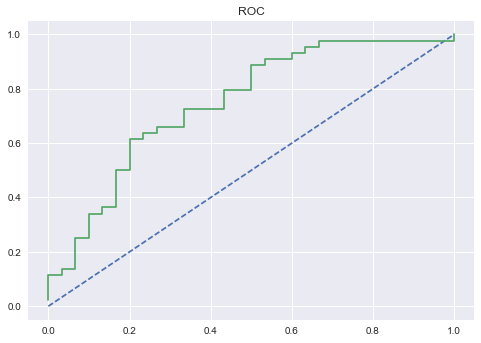

In [284]:
from sklearn.preprocessing import LabelEncoder

X = ndvi_ndwi_data._get_numeric_data().values
y = pd.get_dummies(ndvi_ndwi_data.CONDITION.values)['FAVOURABLE'].values
idx = np.arange(len(y))
year_bins = pd.cut(ndvi_ndwi_data.COND_DATE.dt.year,
                   bins=[2004, 2009, 2011, 2013, 2016])
year_le = LabelEncoder().fit(year_bins.cat.categories)
strat = year_le.transform(year_bins)

X = knn_impute(X, np.isnan(X), k=10)
(X_train, X_test,
 y_train, y_test, 
 idx_train, idx_test) = train_test_split(X, y, idx,
                                         test_size=0.2,
                                         random_state=10111,
                                         stratify=strat)

rf = RandomForestClassifier(n_estimators=50,
                            random_state=1000,
                            max_depth=4).fit(X_train, y_train)
print('Score:', rf.score(X_test, y_test))
pred = rf.predict(X_test)
print(confusion_matrix(pred, y_test))
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], ls='--')
plt.plot(fpr, tpr)
ax.set_title('ROC')
plt.show()

Prediction outcomes actually appear to be relatively independent of the years the assessment was made.

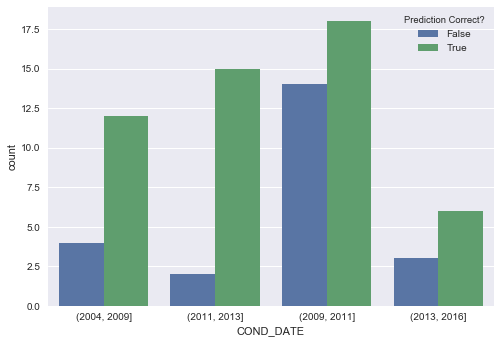

In [301]:
tested_years = year_bins[ndvi_ndwi_data.index.values[idx_test]]
outcomes = pd.Series(pred == y_test,
                     index=ndvi_ndwi_data.index.values[idx_test],
                     name='Prediction Correct?')
tested_data = pd.DataFrame([tested_years, outcomes]).T
sns.countplot(x='COND_DATE', hue='Prediction Correct?', data=tested_data)
plt.show()